<a href="https://colab.research.google.com/github/Pshemeqq18/CART_Regression/blob/main/CIFAR10_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import os

# Sprawdzenie dostępności GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

# Ustawienie ziarna losowości dla reprodukowalności
torch.manual_seed(10)

Używane urządzenie: cpu


In [ ]:
#jeśli masz obraz RGB, gdzie wartości pikseli są między 0 a 255, po ToTensor() będą między 0 a 1, a po Normalize() będą między -1 a 1.
transform_image = transforms.Compose([
    transforms.ToTensor(),                 # Konwersja do tensora
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizacja
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_image)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_image)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#dzielimy na partie po 64 obrazy dla szybszego uczenia i wydajności
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
#Model
class CIFAR10CNN(nn.Module):
    def __init__(self, num_classes=len(classes)):
        super(CIFAR10CNN, self).__init__()

        # Pierwsza warstwa konwolucyjna
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 5),  # Wejście 3 kanały (RGB), filtr 5x5px
            #Zamienia ujemne wartości na 0, dodatnie pozostawia bez zmian, przepuszcza tylko dodatnie informacje
            nn.BatchNorm2d(16), # Normalizacja
            nn.ReLU(inplace=True),  # Funkcja aktywacji ReLU
            nn.MaxPool2d(2, 2)  # Pooling redukujący wymiary
        )

        # Druga warstwa konwolucyjna
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(16, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Warstwa w pełni połączona (fully connected), klasyfikuje do jednej klasy
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.Dropout(0.4),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.Dropout(0.4),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)  # Warstwa wyjściowa
        )

    def forward(self, x):
        # Przepływ danych przez kolejne warstwy
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)

        # Spłaszczenie tensora przed warstwami w pełni połączonymi
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)

        return x

# Inicjalizacja modelu
model = CIFAR10CNN().to(device)

In [ ]:
model

CIFAR10CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1600, out_features=256, bias=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
#CrossEntropyLoss oceni, jak blisko jesteś prawidłowej odpowiedzi
#Adam to model optymalizujacy nauke

criterion = nn.CrossEntropyLoss()  # Funkcja straty dla klasyfikacji wieloklasowej
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Optymalizator Adam

In [ ]:
#Implementacja pętli treningowej
def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=8):
    # Historia metryk do śledzenia postępów
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    correct_labels = {}
    predicted_labels = {}

    # Główna pętla treningowa
    for epoch in range(num_epochs):
        model.train()  # Przełączenie modelu w tryb treningowy
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Iteracja po mini-partiach dla treningu
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            # Przeniesienie danych na odpowiednie urządzenie (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Wyzerowanie gradientów, aby startować od zera przy każdym nowym
            optimizer.zero_grad()

            # Przepuszczenie przez sieć
            outputs = model(inputs)

            # Obliczenie straty (blad miedzy przewidywaniami a realnymi danymi)
            loss = criterion(outputs, labels)

            # Wsteczna propagacja
            loss.backward()

            # Aktualizacja wag
            optimizer.step()

            # Statystyki treningu
            running_loss += loss.item()

            # Obliczenie dokładności
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        # Obliczenie dokładności treningowej
        train_accuracy = 100.0 * correct_train / total_train
        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Ewaluacja na zbiorze testowym
        model.eval()  # Przełączenie modelu w tryb ewaluacji
        correct_test = 0
        total_test = 0

        #dla testowego
        with torch.no_grad():  # Wyłączenie obliczania gradientów
            correct_labels[epoch] = []
            predicted_labels[epoch] = []
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += predicted.eq(labels).sum().item()
                correct_labels[epoch].append(labels.tolist())
                predicted_labels[epoch].append(predicted.tolist())

        test_accuracy = 100.0 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        # Wyświetlenie postępów co każdą epokę
        print(f'Epoka [{epoch+1}/{num_epochs}]')
        print(f'Strata treningowa: {running_loss / len(trainloader):.4f}')
        print(f'Dokładność treningowa: {train_accuracy:.2f}%')
        print(f'Dokładność testowa: {test_accuracy:.2f}%')
        print('-' * 50)

    return train_losses, train_accuracies, test_accuracies, correct_labels, predicted_labels

In [ ]:
# Uruchomienie treningu
train_losses, train_accuracies, test_accuracies, correct_labels, predicted_labels = train_model(
    model, trainloader, testloader, criterion, optimizer
)

Epoka [1/8]
Strata treningowa: 1.5872
Dokładność treningowa: 42.10%
Dokładność testowa: 55.35%
--------------------------------------------------
Epoka [2/8]
Strata treningowa: 1.2581
Dokładność treningowa: 55.92%
Dokładność testowa: 63.01%
--------------------------------------------------
Epoka [3/8]
Strata treningowa: 1.1241
Dokładność treningowa: 60.82%
Dokładność testowa: 65.56%
--------------------------------------------------
Epoka [4/8]
Strata treningowa: 1.0391
Dokładność treningowa: 64.05%
Dokładność testowa: 68.39%
--------------------------------------------------
Epoka [5/8]
Strata treningowa: 0.9670
Dokładność treningowa: 66.93%
Dokładność testowa: 69.50%
--------------------------------------------------
Epoka [6/8]
Strata treningowa: 0.9136
Dokładność treningowa: 68.61%
Dokładność testowa: 69.87%
--------------------------------------------------
Epoka [7/8]
Strata treningowa: 0.8726
Dokładność treningowa: 70.32%
Dokładność testowa: 72.07%
-----------------------------

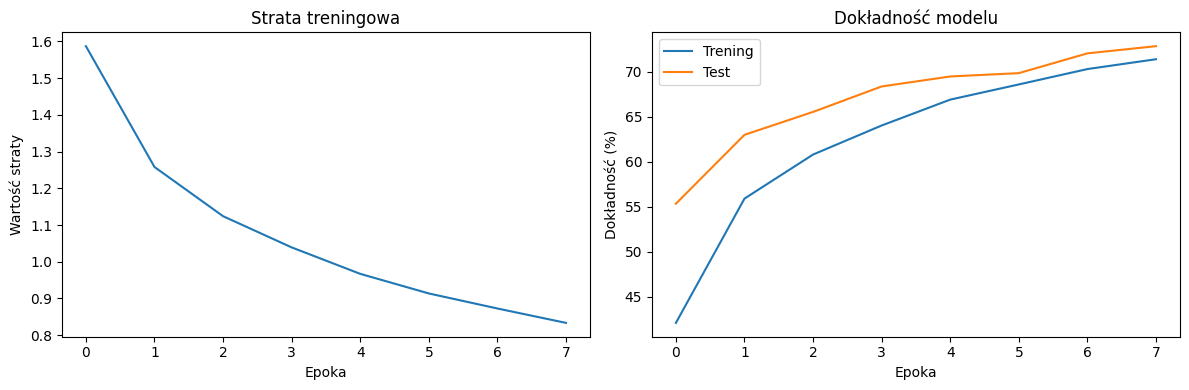

In [ ]:
# Wizualizacja wyników
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Strata treningowa')
plt.xlabel('Epoka')
plt.ylabel('Wartość straty')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Trening')
plt.plot(test_accuracies, label='Test')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prawdziwe i wytypowane przez model klasy
last_correct_labels = [j for i in correct_labels[7] for j in i]
last_predicted_labels = [j for i in predicted_labels[7] for j in i]
label_prediction_data = pd.DataFrame({
    'correct_label': last_correct_labels,
    'predicted_label': last_predicted_labels
})
label_map = {
    0:'plane',
    1:'car',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}
label_prediction_data.replace({'correct_label': label_map, 'predicted_label': label_map}, inplace=True)
label_prediction_data

,correct_label,predicted_label
0,cat,cat
1,ship,car
2,ship,ship
3,plane,plane
4,frog,frog
...,...,...
9995,ship,cat
9996,cat,frog
9997,dog,dog
9998,car,car


In [ ]:
# Tabela z podliczonym występowaniem każdej kombinacji prawdziwa klasa - wytypowana klasa
prediction_summary = label_prediction_data.groupby(["correct_label", "predicted_label"]).size().reset_index().rename(columns={0:'count'})
prediction_summary["is_correct"] = np.where(prediction_summary['correct_label']==prediction_summary['predicted_label'], True, False)
prediction_summary

,correct_label,predicted_label,count,is_correct
0,bird,bird,685,True
1,bird,car,3,False
2,bird,cat,40,False
3,bird,deer,95,False
4,bird,dog,53,False
...,...,...,...,...
94,truck,frog,6,False
95,truck,horse,20,False
96,truck,plane,27,False
97,truck,ship,20,False


In [ ]:
# Utworzenie dwóch dataframów dla policzenia precyzji i czułości
precision_df = prediction_summary.groupby(['predicted_label', 'is_correct'])['count'].sum().reset_index()
recall_df = prediction_summary.groupby(['correct_label', 'is_correct'])['count'].sum().reset_index()

In [ ]:
# Wyliczenie precyzji i czułości dla każdej z klas
for x in classes:
  TP = precision_df[precision_df['predicted_label'] == x].loc[precision_df['is_correct'] == True, 'count'].iloc[0]
  FP = precision_df[precision_df['predicted_label'] == x].loc[precision_df['is_correct'] == False, 'count'].iloc[0]
  FN = recall_df[recall_df['correct_label'] == x].loc[recall_df['is_correct'] == False, 'count'].iloc[0]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  print(x)
  print("Precision: ", str(round(precision*100, 2))+" %")
  print("Recall: ", str(round(recall*100, 2))+" %")

plane
Precision:  75.17 %
Recall:  79.0 %
car
Precision:  84.27 %
Recall:  85.7 %
bird
Precision:  56.47 %
Recall:  68.5 %
cat
Precision:  54.53 %
Recall:  50.6 %
deer
Precision:  63.74 %
Recall:  79.1 %
dog
Precision:  65.58 %
Recall:  54.3 %
frog
Precision:  83.1 %
Recall:  75.7 %
horse
Precision:  83.65 %
Recall:  74.2 %
ship
Precision:  85.4 %
Recall:  81.9 %
truck
Precision:  82.59 %
Recall:  79.7 %


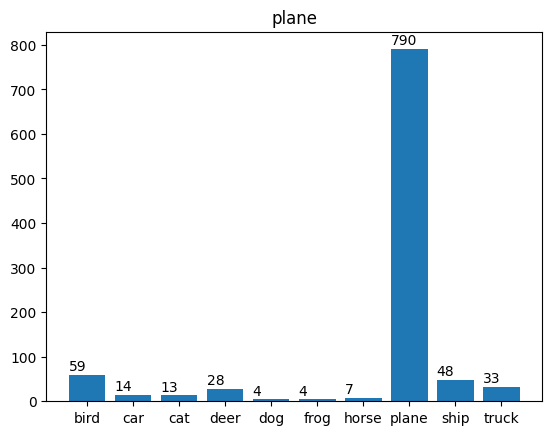

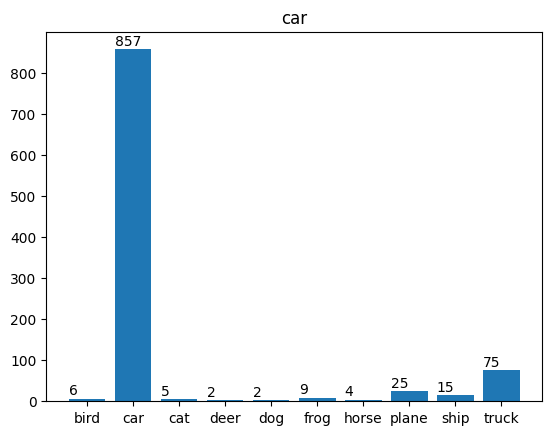

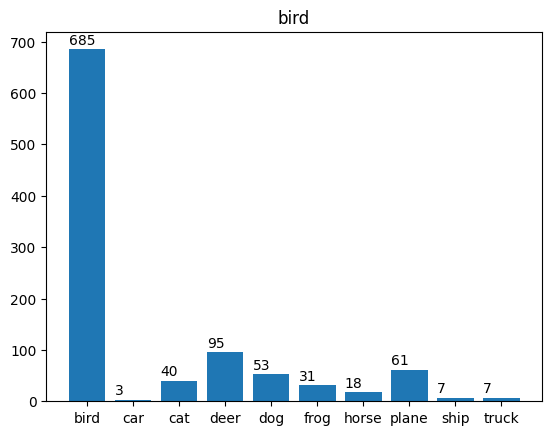

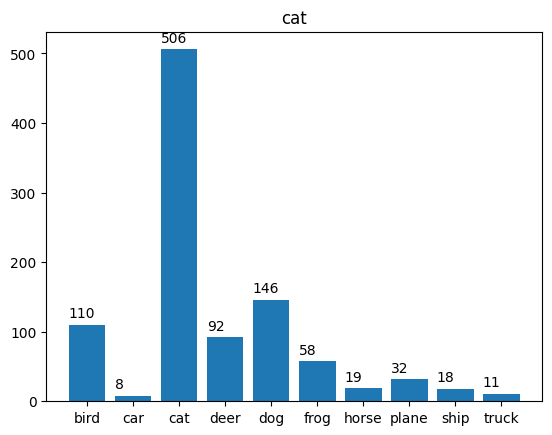

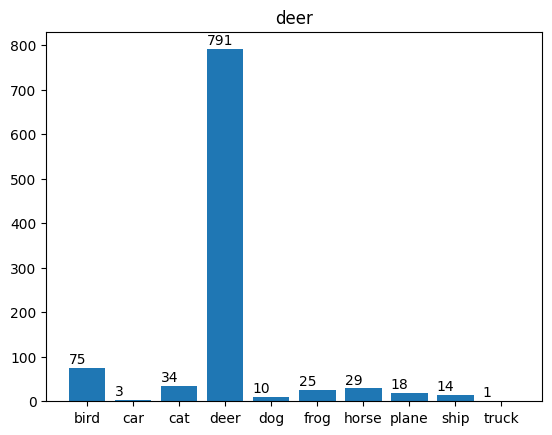

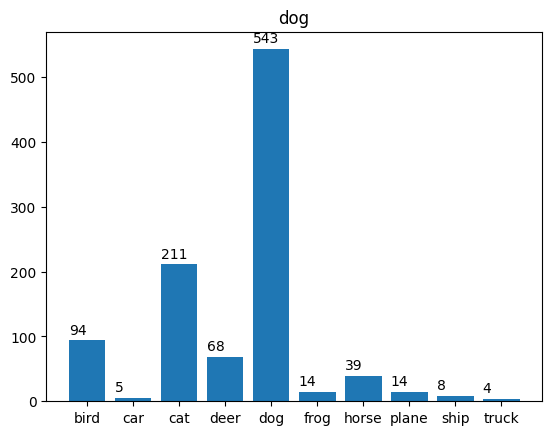

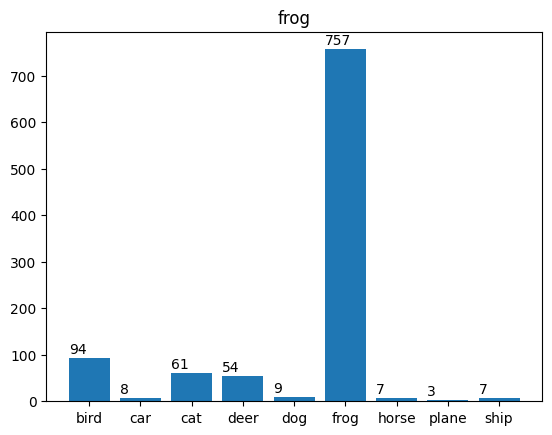

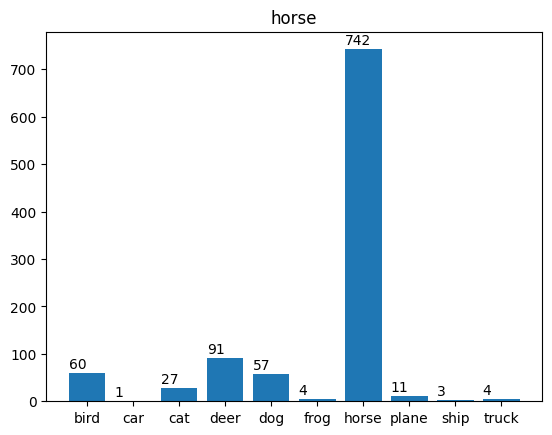

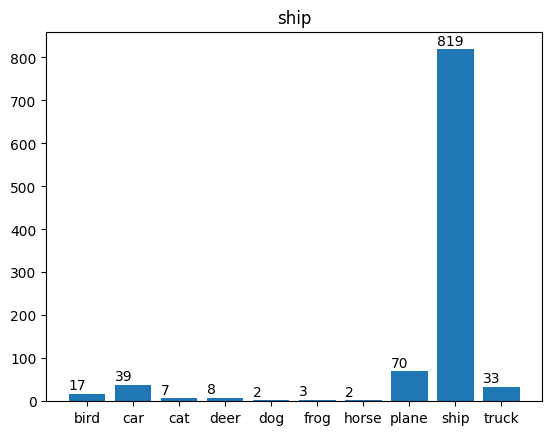

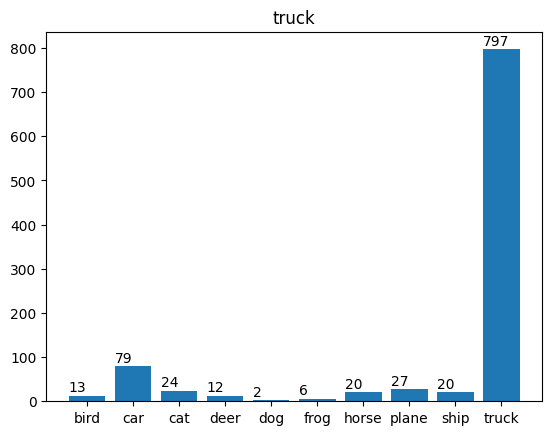

In [ ]:
# Wykres dla każdej klasy przedstawiający co model "typował" jako właściwą klasę
for i in range(10):
  temp_df = prediction_summary[prediction_summary['correct_label'] == classes[i]]
  plt.figure()
  plt.title(classes[i])
  bars = plt.bar(temp_df['predicted_label'], temp_df['count'])
  for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 10, yval)
  plt.show()